In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
df = pd.read_csv('../data/tox_with_sent_nulls_dropped.csv')

In [63]:
df.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
0,0,0,0,0,0,0,1,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...,0.5574,0.000,0.897,0.103
1,0,0,0,0,0,0,1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...,0.2942,0.099,0.743,0.158


In [64]:
df.shape

(159565, 13)

In [65]:
df.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
cleaner_text     0
compound         0
neg              0
neu              0
pos              0
dtype: int64

In [66]:
df[df['cleaner_text'].isnull()]

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos


nulls showed up after cleaning comment text - the text that was there were just links and html, so I'll just drop those rows. I don't understand why they didn't show as nulls when i checked for them before exporting as csv, but they're there..

In [67]:
df.dropna(inplace = True)

In [68]:
df.shape

(159565, 13)

In [69]:
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "neutral"]
toxicity_count = df[toxicity_classes].apply(pd.value_counts).T
toxicity_count[1][:-1]

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
Name: 1, dtype: int64

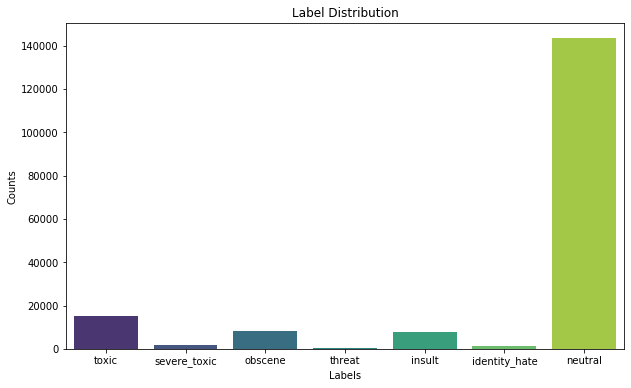

In [71]:
data = {
    'Labels': ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'neutral'],
    'Counts': [15294, 1595, 8449, 478, 7877, 1405, 143340]
}

plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Counts', data=data, palette='viridis')  # Use Seaborn's barplot
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')


plt.savefig("label_distributions.png", dpi=300, bbox_inches="tight") 

In [73]:
toxicity_proportion = df[toxicity_classes].apply(lambda x: x.value_counts(normalize=True)).T
toxicity_proportion

,0,1
toxic,0.904152,0.095848
severe_toxic,0.990004,0.009996
obscene,0.947050,0.052950
threat,0.997004,0.002996
insult,0.950635,0.049365
identity_hate,0.991195,0.008805
neutral,0.101683,0.898317


Alright, so once I fixed the issue with the neutral column in the earlier notebook (reworked capstone bite 1), it appears that my classes are even more imbalanced that I originally thought.  

Since this dataset is multilabel I want to see what different types of label combinations exist. 

In [74]:
labels_only = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'neutral']]

In [75]:
labels_only.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


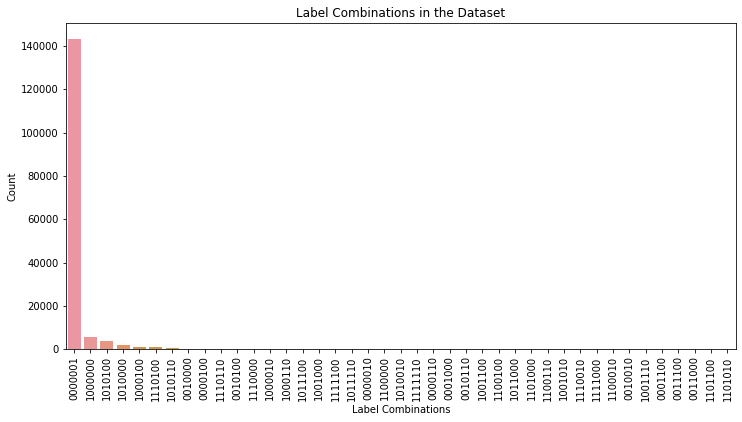

In [76]:
# Get combinations of labels for each observation
label_combinations = labels_only.apply(lambda x: ''.join(x.astype(str)), axis=1)

# Count the occurrences of each label combination
label_combination_counts = label_combinations.value_counts()

# Viz
plt.figure(figsize=(12, 6))
sns.barplot(x=label_combination_counts.index, y=label_combination_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Label Combinations')
plt.ylabel('Count')
plt.title('Label Combinations in the Dataset')
plt.show()

Let's add the actual column names associated with the above combos

In [77]:
#empty list
positive_labels = []

#loop through label combo count index, which has 0/1 combos
for combination in label_combination_counts.index:
    
    #empty label list
    labels = []
    
    #use enumerate to get 0/1 and associated index
    for i, label in enumerate(combination):
        if label == '1':
            #append to labels list if positive
            labels.append(labels_only.index[i])
    positive_labels.append(labels)

# Add the positive_label indexes to the label_combination_counts df
label_combination_counts_df = label_combination_counts.reset_index()
label_combination_counts_df['positive_labels'] = positive_labels
label_combination_counts_df.rename(columns={'index': 'label_combination', 0: 'count'}, inplace=True)

print(label_combination_counts_df[:10])

  label_combination   count  positive_labels
0           0000001  143340              [6]
1           1000000    5666              [0]
2           1010100    3800        [0, 2, 4]
3           1010000    1758           [0, 2]
4           1000100    1215           [0, 4]
5           1110100     989     [0, 1, 2, 4]
6           1010110     618     [0, 2, 4, 5]
7           0010000     317              [2]
8           0000100     301              [4]
9           1110110     265  [0, 1, 2, 4, 5]


In [78]:
# map column names back to indices to have a list of toxicity types rather than index numbers
label_combination_counts_df['label_combos'] = label_combination_counts_df['positive_labels'].apply(lambda indices: list(labels_only.columns[indices]))

In [79]:
label_combination_counts_df.head()

,label_combination,count,positive_labels,label_combos
0,0000001,143340,[6],[neutral]
1,1000000,5666,[0],[toxic]
2,1010100,3800,"[0, 2, 4]","[toxic, obscene, insult]"
3,1010000,1758,"[0, 2]","[toxic, obscene]"
4,1000100,1215,"[0, 4]","[toxic, insult]"


 take them out of the list format... they should probably just be strings...

In [80]:
label_combination_counts_df['label_combos'] = label_combination_counts_df['label_combos'].apply(', '.join)

In [81]:
label_combination_counts_df.head()

,label_combination,count,positive_labels,label_combos
0,0000001,143340,[6],neutral
1,1000000,5666,[0],toxic
2,1010100,3800,"[0, 2, 4]","toxic, obscene, insult"
3,1010000,1758,"[0, 2]","toxic, obscene"
4,1000100,1215,"[0, 4]","toxic, insult"


I'll set the label_combos column as the index so I can visualize the counts of each combo

In [82]:
label_combination_counts_df.set_index('label_combos', inplace=True)

In [83]:
label_combination_counts_df.head()

,label_combination,count,positive_labels
label_combos,,,
neutral,0000001,143340,[6]
toxic,1000000,5666,[0]
"toxic, obscene, insult",1010100,3800,"[0, 2, 4]"
"toxic, obscene",1010000,1758,"[0, 2]"
"toxic, insult",1000100,1215,"[0, 4]"


I want to see what the full visualization looks like, but will likely need to scale it back

In [86]:
label_combos_10 = label_combination_counts_df.head(10)[1:11]

In [89]:
label_combos_10

,label_combination,count,positive_labels
label_combos,,,
toxic,1000000,5666,[0]
"toxic, obscene, insult",1010100,3800,"[0, 2, 4]"
"toxic, obscene",1010000,1758,"[0, 2]"
"toxic, insult",1000100,1215,"[0, 4]"
"toxic, severe_toxic, obscene, insult",1110100,989,"[0, 1, 2, 4]"
"toxic, obscene, insult, identity_hate",1010110,618,"[0, 2, 4, 5]"
obscene,0010000,317,[2]
insult,0000100,301,[4]
"toxic, severe_toxic, obscene, insult, identity_hate",1110110,265,"[0, 1, 2, 4, 5]"


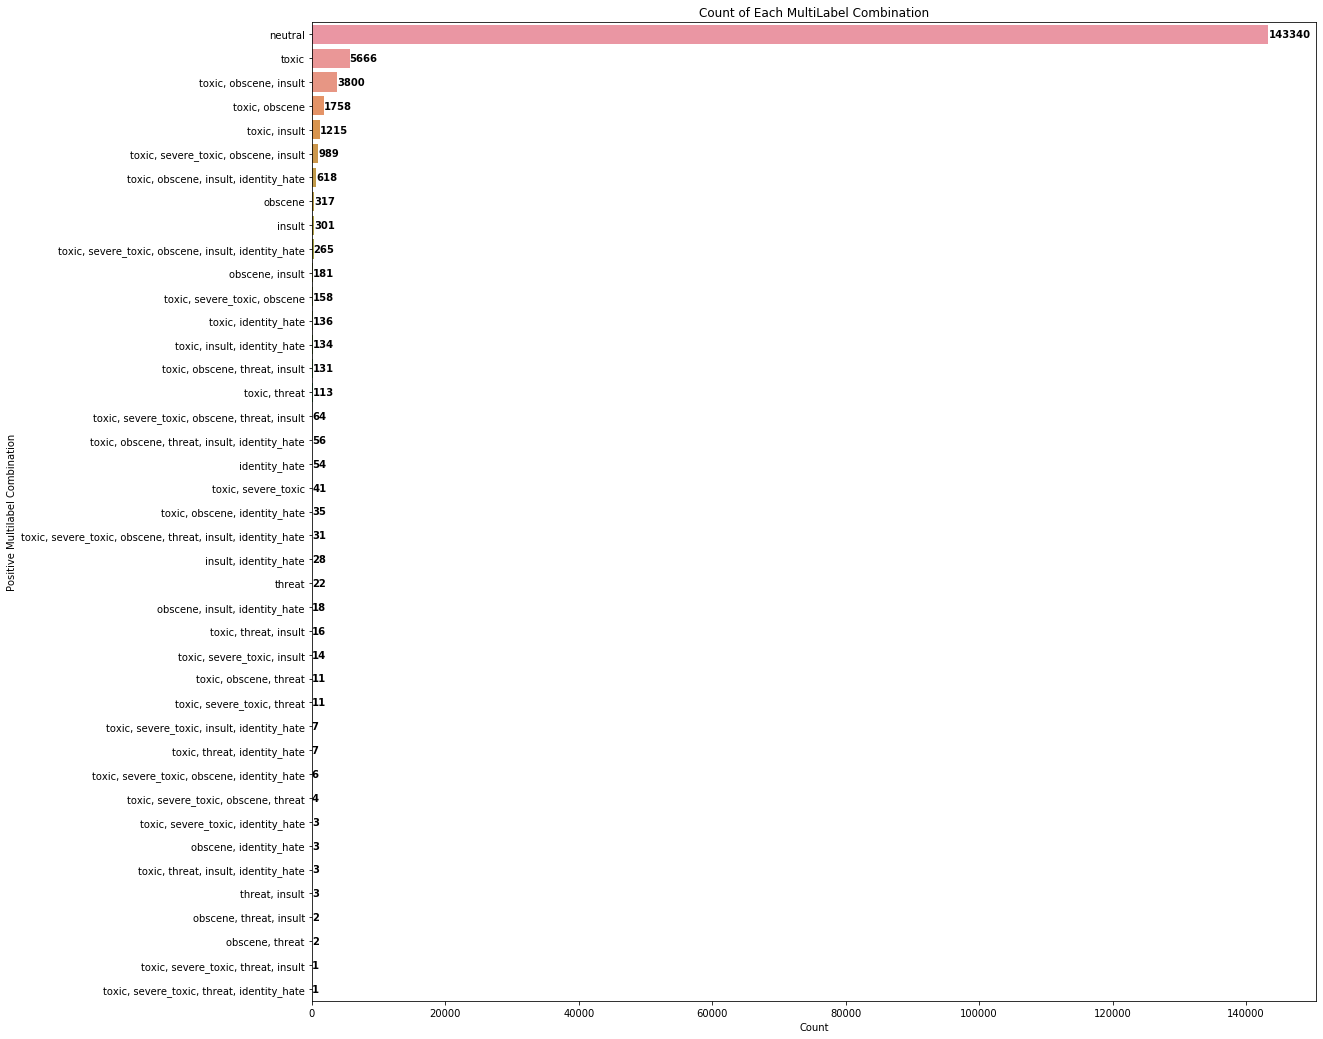

In [88]:
plt.figure(figsize=(18, 18))
ax = sns.barplot(y=label_combination_counts_df.index, x='count', data = label_combination_counts_df, orient = 'h')
plt.title('Count of Each MultiLabel Combination')
plt.ylabel('Positive Multilabel Combination')
plt.xlabel('Count')

# Add count values at the end of each bar
for index, value in enumerate(label_combination_counts_df['count']):
    ax.text(value, index, str(value), ha='left', va='center', color='black', fontweight='bold')

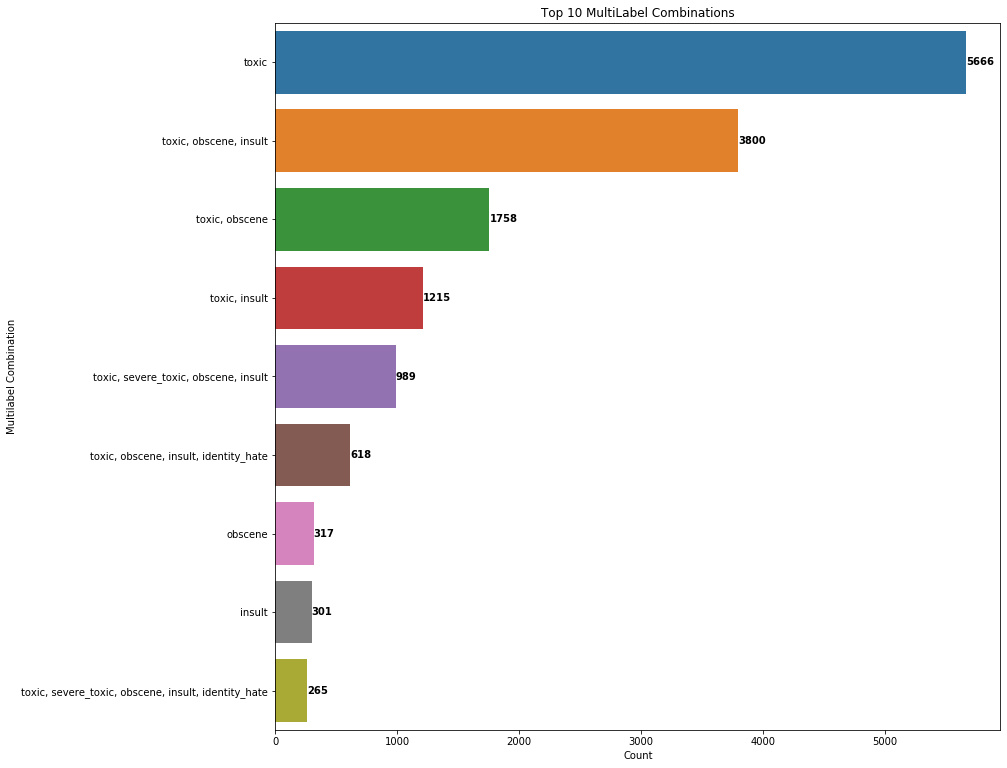

In [90]:
plt.figure(figsize=(13, 13))
ax = sns.barplot(y=label_combos_10.index, x='count', data = label_combos_10, orient = 'h')
plt.title('Top 10 MultiLabel Combinations')
plt.ylabel('Multilabel Combination')
plt.xlabel('Count')

# Add count values at the end of each bar
for index, value in enumerate(label_combos_10['count']):
    ax.text(value, index, str(value), ha='left', va='center', color='black', fontweight='bold')
    
    
plt.savefig("top_10_multilabel_combos.png", dpi=300, bbox_inches="tight") 

Another way to look at this:

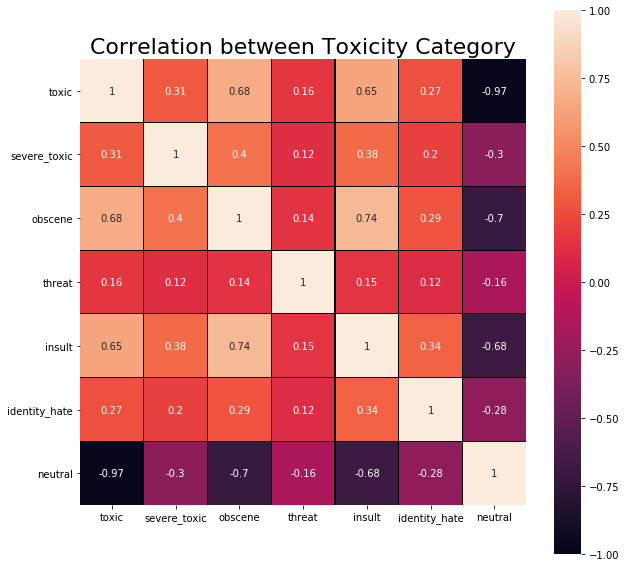

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(df[toxicity_classes].corr(),
            linewidths=0.1,
            linecolor= 'black',
            vmax =1.0,
            vmin = -1.0,
            square=True,
            annot=True,

           );
plt.title('Correlation between Toxicity Category', fontsize=22);




In [29]:
df.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
cleaner_text     0
compound         0
neg              0
neu              0
pos              0
dtype: int64

In [30]:
df.to_csv('tox_with_sent_nulls_dropped.csv', index = False)

In [31]:
### subsample dataset for modeling - trying to keep classes similar to original dataset

https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912

In [50]:
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
0,0,0,0,0,0,0,1,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...,0.5574,0.000,0.897,0.103
1,0,0,0,0,0,0,1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...,0.2942,0.099,0.743,0.158
2,0,0,0,0,0,0,1,"Hey man, I'm really not trying to edit war. It...","Hey man, I'm really not trying to edit war. It...",-0.1779,0.083,0.849,0.068
3,0,0,0,0,0,0,1,"""\nMore\nI can't make any real suggestions on ...",""" More I can't make any real suggestions on im...",0.5106,0.022,0.916,0.062
4,0,0,0,0,0,0,1,"You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember...",0.6808,0.000,0.663,0.337


In [64]:
df.shape

(159565, 13)